# Figure 2 (Part 1). Extracting Timescale from Power Spectrum: Method and Simulation
This notebook walks through the methods used for extracting the characteristic timescale from a (neural) time series (i.e., computing the power spectral density (PSD) and FOOOF). Simulation with autocorrelated noise is used to test the accuracy of the extracted timescale parameters, and applied to an example ECoG spectrum for demonstration purposes.

In [1]:
%load_ext autoreload
%autoreload 2
    
%matplotlib inline
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from fooof import FOOOF, FOOOFGroup
from neurodsp import sim, spectral
from seaborn import despine

from scipy import io, stats, optimize
from statsmodels.tsa.stattools import acf

sys.path.append('../')
import echo_utils

font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 14}
plt.rc('font', **font)

fig_path = '../figures/sim/%s.pdf'
save_plot=True

********************************************************************************
         to build the TVTK classes (8.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



---
### Defining timescale
Here, and throughout the rest of the study, "timescale" is defined as the exponential decay time constant of the autocorrelation of a time series. According to the Wiener-Khinchin theorem, the power spectral density (PSD) of a signal is the Fourier transform of its autocorrelation. This theorem is typically invoked when the signal is non-square integrable for computing its autocorrelation, but here we simply apply it for convenience to the discrete-time signals that we work with, in order to measure timescale from the spectral representation. 

If a signal has an exponential decay autocorrelation, its power spectrum will then have the "Lorentzian" form:

$$ P(f) = {A\over(k+f^2)} $$

FOOOF fits a more general Lorentzian function to neural power spectra (with a variable exponent, $\chi$, instead of fixed at 2):

$$ P(f) = {A\over(k+f^\chi)} $$

where the power law exponent ($\chi$) and the knee (k) parameters jointly define the decay timescale back in the time domain. The expression for converting between frequency and time domain parameters are shown below, and validated with simulated noise signals with different decay time constants, or timescales.

---
### Exponentially decaying synaptic potentials
Synaptic currents are almost always modeled as exponentially decaying (or alpha-shaped) functions, which has a plateau up to some characteristic frequency ("knee frequency"), and a power-law decay with exponent of 2 past that. The decay time constant maps one-to-one onto the knee frequency:

$f_{knee}\approx\sqrt[\chi] k$, and

$\tau = \frac{1}{2\pi}\sqrt[\chi]{\frac{1}{k}}$ or $\frac{1}{2\pi}\frac{1}{f_{knee}}$



Here, $\chi=2$ for exponentially decaying signals, but this can also vary in brain signals as a function of brain region and state.

- http://mathworld.wolfram.com/FourierTransformExponentialFunction.html
- http://www.thefouriertransform.com/pairs/decayingexponential.php

---
In this first section, we simply simulate an exponential decay kernel with known time constant, then try to retrieve it in the spectral domain, from its squared Fourier magnitude (no stochastic noise yet).

In [99]:
fs = 2000.
t_sim = 2.
t_ker = np.arange(0,t_sim,1/fs)
t_r = 0
t_ds = np.arange(0.005,0.08,0.01)
f_to_plot=200
kernels = []

# get synaptic kernels
for t_d in t_ds:
    ker = sim.sim_synaptic_kernel(t_sim, fs, tau_r=t_r, tau_d=t_d)
    kernels.append(ker/ker[0])

kernels = np.array(kernels).T

# compute spectrum via FFT
f_axis = np.fft.fftfreq(len(t_ker), 1/fs)[:int(np.floor(len(t_ker)/2))]
PSDs = (np.abs(sp.fft(kernels, axis=0))**2)[:len(f_axis)]

# fit FOOOF & get knee parameter & convert to timescale
fooof = FOOOFGroup(aperiodic_mode='knee', max_n_peaks=0)
fooof.fit(freqs=f_axis, power_spectra=PSDs.T,freq_range=(2,200))
fit_knee = fooof.get_params('aperiodic_params', 'knee')
fit_exp = fooof.get_params('aperiodic_params', 'exponent')
knee_freq, taus = echo_utils.convert_knee_val(fit_knee, fit_exp)

P_knee = [PSDs[np.argmin(np.abs((f_axis[:f_to_plot]-(knee_freq[i])))),i] for i in range(len(t_ds))]

Running FOOOFGroup across 8 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.


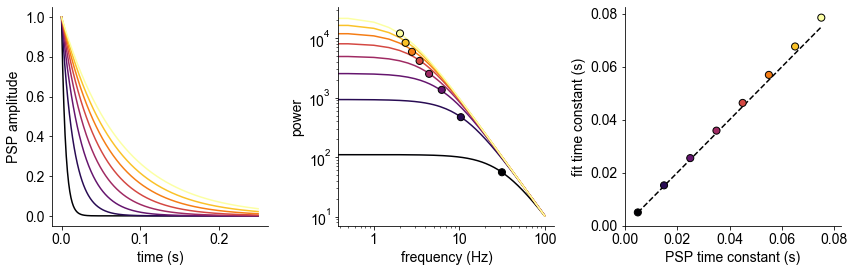

In [100]:
color = plt.cm.inferno(np.linspace(0,1,len(t_ds)))
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', color)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(t_ker[:500], kernels[:500,:])
plt.xlabel('time (s)'); plt.ylabel('PSP amplitude')

plt.subplot(1,3,2)
plt.loglog(f_axis[:f_to_plot], PSDs[:f_to_plot,:]);
plt.scatter(knee_freq,P_knee, c=color, s=50, edgecolor='k', zorder=100)
plt.xlabel('frequency (Hz)'); plt.ylabel('power')
plt.xticks([1, 10, 100], ['1','10','100'])

plt.subplot(1,3,3)
plt.scatter(t_ds,taus, c=color, s=50, edgecolor='k', zorder=100)
plt.plot(t_ds, t_ds, 'k--');
plt.xlim([0,t_ds.max()*1.1]);plt.ylim([0,t_ds.max()*1.1])
plt.xlabel('PSP time constant (s)'); plt.ylabel('fit time constant (s)')
[despine() for a in plt.gcf().axes]
plt.tight_layout()

if save_plot: plt.savefig(fig_path%'kernel_analytic')

In the left and middle plot above are the PSP kernel (not the autocorrelation) and the power spectrum (notice the plateau and subsequent 1/f falloff), respectively. Circles in middle plot correspond to FOOOF-fitted knee frequencies. The groundtruth and inferred PSP time constants are plotted on the right, showing a close correspondence.

---
# Timescale of spontaneous synaptic fluctuations
Using those synaptic kernels with varying decay constants, we can simulate synaptic fluctuations over time by simply convolving white noise (approximating Poisson population spiking) with the kernels. This will produce time series with varying autocorrelation time constants, and thus PSD knee frequencies. We will then FOOOF and fit the knee parameter (k), retrieve the time constant with the equation above, and confirm that we get back the parameter values we put in. It's essentially the same experiment as above, but with some level of stochasticity injected.

In [101]:
# simulate noise
T = 240
noise, ac = [], []
for t_d in t_ds:
    noise.append(sim.sim_synaptic_current(T, fs, tau_d = t_d))
    #ac.append(sp.signal.correlate(noise[-1], noise[-1])[int(T*fs)-1:])
    ac.append(acf(noise[-1], nlags=int(fs), fft=True))

noise = np.vstack(noise)
ac = np.vstack(ac).T

f_axis, PSD = spectral.compute_spectrum(noise,fs)

# FOOOF PSDs without knee
fg = FOOOFGroup(aperiodic_mode='knee', max_n_peaks=0)
fg.fit(freqs=f_axis, power_spectra=PSD, freq_range=(2,200))
fit_knee = fg.get_params('aperiodic_params', 'knee')
fit_exp = fg.get_params('aperiodic_params', 'exponent')
knee_freq, taus = echo_utils.convert_knee_val(fit_knee, fit_exp)
P_knee = [PSD[i,np.argmin(np.abs((f_axis[:f_to_plot]-(knee_freq[i]))))] for i in range(len(t_ds))]

Running FOOOFGroup across 8 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



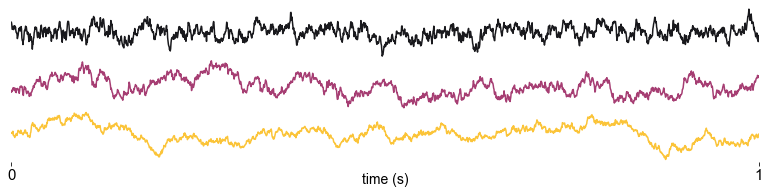

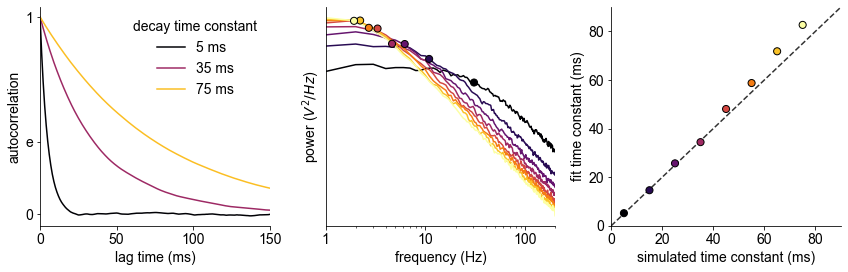

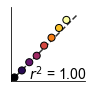

In [105]:
i_plot = [0,3,7]
t = np.arange(0,T,1/fs)
plt.figure(figsize=(10.5,2.5))
for p in range(3):
    plt.subplot(3,1,p+1)
    plt.plot(t[:int(fs)], noise.T[:int(fs),i_plot[p]], alpha=0.9, color=np.array(plt.cycler('color', plt.cm.inferno(np.linspace(0,0.85,3))))[p]['color'])
    plt.xticks([]); plt.yticks([])
    plt.xlim([0,1]); 
    
plt.xlabel('time (s)', labelpad=-10)
plt.xticks([0,1], fontsize=15); 
despine(bottom=True, left=True)
plt.tight_layout(pad=0)
if save_plot: plt.savefig(fig_path%'noise_ts_seg', bbox_inches='tight')

plt.figure(figsize=(12,4))
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.inferno(np.linspace(0,0.85,3)))
plt.subplot(1,3,1)
plt.plot(t_ker[:500]*1000, ac[:500,i_plot]/ac[0,i_plot])
plt.xlim([0,150]); plt.yticks([0,np.exp(-1), 1], ['0','e','1']);#plt.yticks([0,0.5,1])
plt.xlabel('lag time (ms)'); plt.ylabel('autocorrelation')
plt.legend(['%i ms'%np.round(tt) for tt in t_ds[i_plot]*1000], frameon=False, loc='upper right', title='decay time constant')

plt.rcParams['axes.prop_cycle'] = plt.cycler('color',color)
plt.subplot(1,3,2)
plt.loglog(f_axis[:f_to_plot], PSD[:,:f_to_plot].T);
plt.scatter(knee_freq,P_knee, c=color, s=50, edgecolor='k', zorder=100)
plt.yticks([]); plt.tick_params('y', which='minor', left=False, labelleft=False)
plt.xlabel('frequency (Hz)'); plt.ylabel(r'power ($V^2/Hz$)')
plt.xticks([1, 10, 100], ['1','10','100']); plt.xlim([1,200]);

plt.subplot(1,3,3)
plt.scatter(t_ds*1000,taus*1000, c=color, s=50, edgecolor='k', zorder=100)
plt.xlim([0,t_ds.max()*1200]);plt.ylim([0,t_ds.max()*1200])
plt.plot(plt.xlim(), plt.xlim(), 'k--', alpha=0.8);
plt.xlabel('simulated time constant (ms)'); plt.ylabel('fit time constant (ms)')

despine()
plt.tight_layout()

if save_plot: plt.savefig(fig_path%'noise_spectral')

### plot a smaller one for figure inset
plt.figure(figsize=(1.5,1.5))
plt.scatter(t_ds*1000,taus*1000, c=color, s=50, edgecolor='k', zorder=100)
plt.xticks([]);plt.yticks([])
plt.xlim([0,100]);plt.ylim([0,100])
plt.plot([0,90], [0,90], 'k--', alpha=0.8);
plt.annotate(r'$r^2$ = %.2f'%stats.pearsonr(t_ds,taus)[0]**2, xy=(0.25, 0.025), xycoords='axes fraction', fontsize=14)
despine()
plt.tight_layout()
if save_plot: plt.savefig(fig_path%'sim_corr_inset', bbox_inches='tight')

# Success!
As expected, we can retrieve autocorrelation decay time constants (timescales) from the power spectrum, even in stochastic signals. The advantage of this approach -- fitting in the frequency domain -- is that oscillations manifest as distinct narrowband peaks in the PSD, and are easily isolated and removed (by FOOOF). In contrast, oscillations in the autocorrelation function are difficult to account for (see an example below), and we essentially have to fit the envelope, in addition to long timescale/scalefree processes that "stretch out" the decay time constant. This latter part is taken into account via the variable exponent parameter, $\chi$.

---
# Fitting real ECoG data
In the cells below, we show an example of fitting the periodic-aperiodic FOOOF model to real macaque ECoG power spectrum, and extracting its characteristic timescale.

In [107]:
datafolder = '/Users/rdgao/Documents/data/NeuroTycho/Propofol/20120802PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/Session1/'
chan = 20 #45 #20 #127
data_exmp = io.loadmat(datafolder+'ECoG_ch%i.mat'%chan, squeeze_me=True)['ECoGData_ch%i'%chan]
cond = io.loadmat(datafolder+'Condition.mat', squeeze_me=True)
data = data_exmp[cond['ConditionIndex'][2]:cond['ConditionIndex'][3]]
fs = 1000


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

knee frequency: 19.395Hz, time constant: 8.206ms, exponent: 3.815


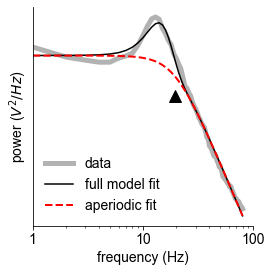

In [108]:
fit_range=[1,80]
plt_inds = np.arange(fit_range[0],fit_range[1]+1)
faxis, psd = spectral.compute_spectrum(data,fs,avg_type='median')

# fit fooof without knee
fo0 = FOOOF(max_n_peaks=2, aperiodic_mode='fixed')
fo0.fit(faxis, psd, fit_range)

# fit fooof with knee
fok = FOOOF(max_n_peaks=2, aperiodic_mode='knee')
fok.fit(faxis, psd, fit_range)
offset, knee, exp = fok.get_params('aperiodic_params')
kfreq, tau = echo_utils.convert_knee_val(knee,exp)

plt.figure(figsize=(4,4))
plt.loglog(faxis[plt_inds], psd[plt_inds], 'k', lw=5, alpha=0.3)
plt.loglog(faxis[plt_inds], 10**fok.fooofed_spectrum_, 'k-')
plt.loglog(faxis[plt_inds], 10**offset/(knee+faxis**exp)[plt_inds], '--r', lw=2)

plt.xlim([1,100])
plt.xlabel('frequency (Hz)');plt.ylabel('power');
plt.xticks([1, 10, 100], ['1','10', '100']);plt.yticks([]);
plt.legend(['data', 'full model fit', 'aperiodic fit'], frameon=False)
plt.yticks([]); plt.tick_params('y', which='minor', left=False, labelleft=False)
plt.xlabel('frequency (Hz)'); plt.ylabel(r'power ($V^2/Hz$)')

plt.plot(kfreq, 10**offset/(knee+faxis**exp)[np.where(faxis==np.round(kfreq))[0]]*0.5, '^k', ms=12)

despine(); plt.tight_layout()
plt.savefig(fig_path%'fooof_schematic')
print('knee frequency: %.3fHz, time constant: %.3fms, exponent: %.3f'%(kfreq, 1000*tau, exp))

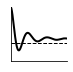

In [9]:
# compute autocorrelation function
max_lag=250
t_ac = np.arange(0,max_lag+1)/fs
ac = acf(data, nlags=max_lag, fft=True)

# plot a tiny autocorrelation function for figure inset
plt.figure(figsize=(1,1))
plt.plot(t_ac*1000, ac, 'k', lw=2)
plt.axhline(0, lw=1, ls='--', color='k')
plt.xlim([0,250])
plt.xticks([]); plt.yticks([]); plt.ylim([-0.5,1])
despine()
plt.savefig(fig_path%'acf_schematic')

In the plot above, we can see the impact of an oscillatory component in the signal on its power spectrum and autocorrelation function. FOOOF retrieves the aperiodic background well (by visual inspection, red dotted line), and the knee frequency is denoted with the black triangle.

In contrast, fitting the time constant (tau) to the autocorrelation funciton is less clear in the presence of such a strong oscillation. Below is an example of the time series to demonstrate the oscillation.

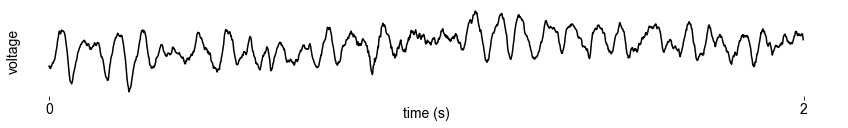

In [10]:
plt.figure(figsize=(12,2))
plt.plot(np.arange(0,fs*2)/fs, data[:int(fs*2)])
plt.xticks([0,2]); plt.xlabel('time (s)', labelpad=-10)
plt.yticks([]); plt.ylabel('voltage', labelpad=-10)
despine(left=True, bottom=True); plt.tight_layout()

---
# Supplemental: semilog vs. log-log
Just a pedantic example to show that the low-frequency plateau (characteristic frequency) is very obvious in the log-log (right) plot, and not at all in the semilog (middle) plot.

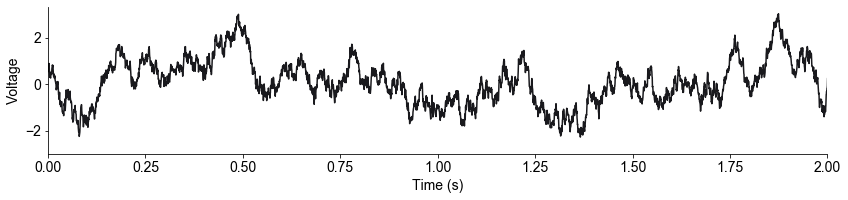

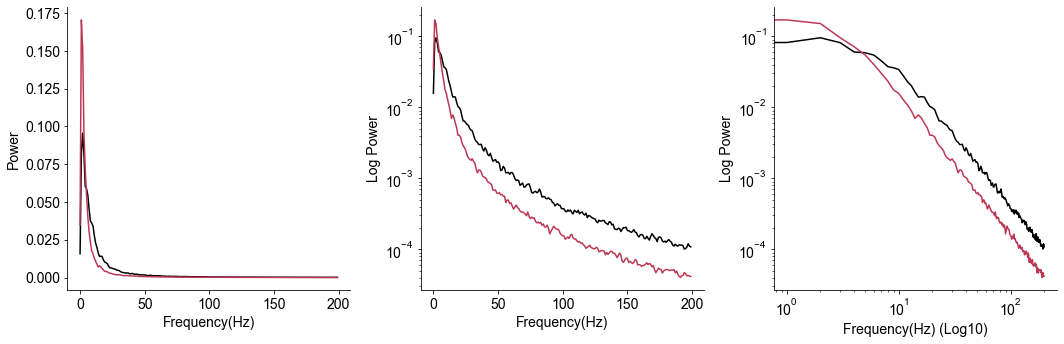

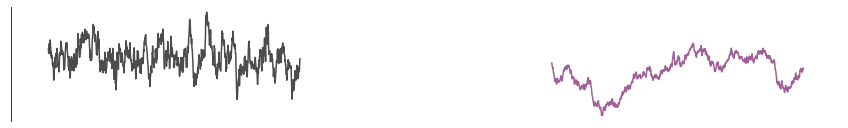

In [11]:
plt.figure(figsize=(12,3))

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.inferno(np.linspace(0,1,3)))
plt.plot(t[:int(fs*30)], noise.T[:int(fs*30),5], alpha=0.9)
plt.xlabel('Time (s)'); plt.ylabel('Voltage')
plt.xlim([0,2]);despine()
plt.tight_layout()


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(f_axis[:f_to_plot], PSD[-6:-1:4,:f_to_plot].T);
plt.xlabel('Frequency(Hz)');plt.ylabel('Power')

plt.subplot(1,3,2)
plt.semilogy(f_axis[:f_to_plot], PSD[-6:-1:4,:f_to_plot].T);
plt.xlabel('Frequency(Hz)');plt.ylabel('Log Power')


plt.subplot(1,3,3)
plt.loglog(f_axis[:f_to_plot], PSD[-6:-1:4,:f_to_plot].T);
plt.xlabel('Frequency(Hz) (Log10)');plt.ylabel('Log Power')
despine()
plt.tight_layout()

plt.figure(figsize=(12,2))
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.inferno(np.linspace(0,1,4)))
plt.plot(t[:int(fs)], noise.T[:int(fs),0], alpha=0.7)
#plt.plot(t[int(fs*1.5):int(fs*2)], noise.T[:int(fs/2),-1], alpha=0.7)
plt.plot(t[int(fs*2):int(fs*3)], noise.T[:int(fs),-1], alpha=0.7)
plt.yticks([])
#plt.xlim([0,3]); 
#plt.xticks([0,0.9], ['0', '900 ms'], fontsize=20)
plt.xticks([])
despine(bottom=True, left=False); plt.tight_layout()
if save_plot: plt.savefig('../figures/jwm/schematic.png')

---
# Supplemental: fitting multiple timescales

short tau = 8.907 ms
long tau = 1539.033 ms


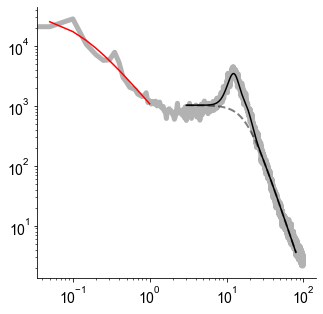

In [12]:
winlen = 20
faxis, psd = spectral.compute_spectrum(data,fs,avg_type='median', nperseg=int(fs*winlen), noverlap=int(fs*winlen*3/4))

plt.figure(figsize=(5,5))
plt.loglog(faxis[:winlen*100], psd[:winlen*100], 'k', lw=5, alpha=0.3)


# fit fooof with high knee
fit_range=[3,80]
plt_inds = np.arange(fit_range[0]*winlen, fit_range[1]*winlen+1).astype(int)
fok = FOOOF(max_n_peaks=2, aperiodic_mode='knee')
fok.fit(faxis, psd, fit_range)
offset, knee, exp = fok.get_params('aperiodic_params')
kfreq, tau = echo_utils.convert_knee_val(knee,exp)
plt.loglog(faxis[plt_inds], 10**fok.fooofed_spectrum_, 'k-')
plt.loglog(faxis[plt_inds], 10**offset/(knee+faxis**exp)[plt_inds], '--k', lw=2, alpha=0.5)
print('short tau = %.3f ms'%(tau*1000))

# fit fooof with low knee
fit_range=[0.05,1]
plt_inds = np.arange(fit_range[0]*winlen, fit_range[1]*winlen+1).astype(int)
fok = FOOOF(max_n_peaks=2, aperiodic_mode='knee')
fok.fit(faxis, psd, fit_range)
offset, knee, exp = fok.get_params('aperiodic_params')
kfreq, tau = echo_utils.convert_knee_val(knee,exp)
plt.loglog(faxis[plt_inds], 10**fok.fooofed_spectrum_, 'r-')

print('long tau = %.3f ms'%(tau*1000))
despine()

single tau = 9.221 ms
short tau = 8.749 ms, long tau = 1381.189 ms


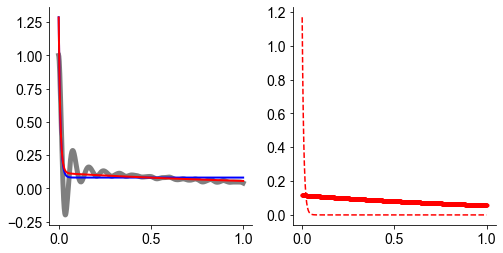

In [13]:
# compute autocorrelation function
max_lag=1000
t_ac = np.arange(0,max_lag+1)/fs
ac = acf(data, nlags=max_lag, fft=True)

p_bounds =([0, 0, 0], [10, np.inf, np.inf])
p_le = optimize.curve_fit(echo_utils.exp_lt_func, t_ac, ac, bounds = p_bounds)[0]
print('single tau = %.3f ms'%(p_le[0]*1000))
p_bounds =([0, 0, 0, 0, 0], [10, 10, np.inf, np.inf, np.inf])
p_2e = optimize.curve_fit(echo_utils.exp2_func, t_ac, ac, bounds = p_bounds)[0]


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(t_ac, ac, 'k', lw=5, alpha=.5)
plt.plot(t_ac, echo_utils.exp_lt_func(t_ac, p_le[0],p_le[1],p_le[2]), 'b', lw=2)
plt.plot(t_ac, echo_utils.exp2_func(t_ac, p_2e[0],p_2e[1],p_2e[2], p_2e[3],p_2e[4]), 'r', lw=2)
despine()

plt.subplot(1,2,2)
plt.plot(t_ac, echo_utils.exp_lt_func(t_ac, p_2e[0],p_2e[2],0), 'r--')
plt.plot(t_ac, echo_utils.exp_lt_func(t_ac, p_2e[1],p_2e[3],0), 'r.-')
despine()
print('short tau = %.3f ms, long tau = %.3f ms'%(min(p_2e[0],p_2e[1])*1000, max(p_2e[0],p_2e[1])*1000))